In [1]:
import tensorrt
import qutip as qt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from qutip import Qobj, wigner
from tqdm import tqdm
import time
import os

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras.regularizers import l2

tf.config.run_functions_eagerly(False)

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Utility functions
def get_vacuum_state_tf(dim):
    vacuum_state = qt.basis(dim, 0)
    return tf.convert_to_tensor(vacuum_state.full(), dtype=tf.complex64)

def annihilation(dim):
    diag_vals = tf.math.sqrt(tf.cast(tf.range(1, dim), dtype=tf.complex64))
    return tf.linalg.diag(diag_vals, k=1)

def number(dim):
    diag_vals = tf.cast(tf.range(0, dim), dtype=tf.complex64)
    return tf.linalg.diag(diag_vals)

def displacement_operator(dim, x, y=0):
    x2 = tf.identity(x)
    y2 = tf.identity(y)
    alpha = tf.complex(x2, y2)
    a = annihilation(dim)
    term1 = alpha * tf.linalg.adjoint(a)
    term2 = tf.math.conj(alpha) * a
    D = tf.linalg.expm(term1 - term2)
    return D

def displacement_encoding(dim, alpha_vec):
    alpha_vec = tf.cast(alpha_vec, dtype=tf.complex64)
    num = tf.shape(alpha_vec)[0]
    a = annihilation(dim)
    term1 = tf.linalg.adjoint(a)
    term2 = a
    term1_batch = tf.tile(tf.expand_dims(term1, 0), [num, 1, 1])
    term2_batch = tf.tile(tf.expand_dims(term2, 0), [num, 1, 1])
    alpha_vec = tf.reshape(alpha_vec, [-1, 1, 1])
    D = tf.linalg.expm(alpha_vec * term1_batch - tf.math.conj(alpha_vec) * term2_batch)
    return D

def rotation_operator(dim, theta):
    theta2 = tf.identity(theta)
    theta2 = tf.cast(theta2, dtype=tf.complex64)
    n = number(dim)
    R = tf.linalg.expm(-1j * theta2 * n)
    return R

def squeezing_operator(dim, r):
    r2 = tf.identity(r)
    r2 = tf.cast(r2, dtype=tf.complex64)
    a = annihilation(dim)
    term1 = r2 * tf.linalg.adjoint(a) * a
    term2 = tf.math.conj(r2) * a * tf.linalg.adjoint(a)
    S = tf.linalg.expm(0.5 * (term1 - term2))
    return S

def kerr_operator(dim, kappa):
    kappa2 = tf.identity(kappa)
    kappa2 = tf.cast(kappa2, dtype=tf.complex64)
    n = number(dim)
    K = tf.linalg.expm(1j * kappa2 * n * n)

    return K

In [5]:
# TensorFlow Custom Layer for Quantum Encoding
class QEncoder(tf.keras.layers.Layer):
    def __init__(self, dim, vacuum_state, **kwargs):
        super(QEncoder, self).__init__(**kwargs)
        self.dim = dim
        self.vacuum_state = tf.cast(vacuum_state, dtype=tf.complex64)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_vacuum_state = tf.tile(tf.expand_dims(self.vacuum_state, axis=0), [batch_size, 1, 1])
        batch_displacement_operators = displacement_encoding(self.dim, inputs)
        displaced_states = tf.einsum('bij,bjk->bik', batch_displacement_operators, batch_vacuum_state)
        return displaced_states


# TensorFlow Custom Layer for Quantum Transformations
class QLayer(tf.keras.layers.Layer):
    def __init__(self, dim, stddev=1.0, l2_lambda=0.01, **kwargs):
        super(QLayer, self).__init__(**kwargs)
        self.dim = dim
        self.stddev = stddev  # Standard deviation as a hyperparameter
        self.l2_lambda = l2_lambda
        self.regularizer = l2(l2_lambda)

    def build(self, input_shape):
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.stddev, seed=42)
        self.theta_1 = self.add_weight("theta_1", shape=[1,], initializer=initializer, trainable=True)
        self.theta_2 = self.add_weight("theta_2", shape=[1,], initializer=initializer, trainable=True)
        self.r = self.add_weight("r", shape=[1,], initializer=initializer, trainable=True)
        self.bx = self.add_weight("bx", shape=[1,], initializer=initializer, trainable=True)
        self.bp = self.add_weight("bp", shape=[1,], initializer=initializer, trainable=True)
        self.kappa = self.add_weight("kappa", shape=[1,], initializer=initializer, trainable=False)

        # Apply regularization manually
        self.add_loss(lambda: self.regularizer(self.theta_1))
        self.add_loss(lambda: self.regularizer(self.theta_2))
        self.add_loss(lambda: self.regularizer(self.r))
        self.add_loss(lambda: self.regularizer(self.bx))
        self.add_loss(lambda: self.regularizer(self.bp))
        #self.add_loss(lambda: self.regularizer(self.kappa))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        D_tensor = tf.expand_dims(displacement_operator(self.dim, self.bx, self.bp), 0)
        R_tensor_1 = tf.expand_dims(rotation_operator(self.dim, self.theta_1), 0)
        S_tensor = tf.expand_dims(squeezing_operator(self.dim, self.r), 0)
        R_tensor_2 = tf.expand_dims(rotation_operator(self.dim, self.theta_2), 0)
        K_tensor = tf.expand_dims(kerr_operator(self.dim, self.kappa), 0)

        D_tensor = tf.tile(D_tensor, [batch_size, 1, 1])
        R_tensor_1 = tf.tile(R_tensor_1, [batch_size, 1, 1])
        S_tensor = tf.tile(S_tensor, [batch_size, 1, 1])
        R_tensor_2 = tf.tile(R_tensor_2, [batch_size, 1, 1])
        K_tensor = tf.tile(K_tensor, [batch_size, 1, 1])

        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_1, inputs)
        transformed_state = tf.einsum('bij,bjk->bik', S_tensor, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', R_tensor_2, transformed_state)
        transformed_state = tf.einsum('bij,bjk->bik', D_tensor, transformed_state)
        activated_state = tf.einsum('bij,bjk->bik', K_tensor, transformed_state)
        
        self.final_state = activated_state
        return activated_state
    
    
# TensorFlow Custom Layer for Quantum Decoding
class QDecoder(tf.keras.layers.Layer):
    def __init__(self, dim, **kwargs):
        super(QDecoder, self).__init__(**kwargs)
        self.dim = dim
        self.x_operator = self.build_x_operator()

    def build_x_operator(self):
        a = annihilation(self.dim)
        x_operator = (a + tf.linalg.adjoint(a)) / 2.0
        x_operator = tf.expand_dims(x_operator, axis=0)  # Add batch dimension
        return x_operator

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        batch_x_operator = tf.tile(self.x_operator, [batch_size, 1, 1])

        # Step 1: Compute \hat{O} | \psi \rangle for each state in the batch
        operator_applied_state = tf.einsum('bij,bjk->bik', batch_x_operator, inputs)

        # Take the complex conjugate of each state and adjust dimensions
        conj_inputs = tf.math.conj(inputs)  # Shape: (batch_size, dim, 1)
        conj_inputs_adj = tf.transpose(conj_inputs, perm=[0, 2, 1])  # Shape: (batch_size, 1, dim)

        # Compute the expectation value (inner product) for each state in the batch
        x_expectation = tf.einsum('bij,bjk->bi', conj_inputs_adj, operator_applied_state) 
        x_expectation = tf.squeeze(x_expectation, axis=-1)

        return tf.math.real(x_expectation)

# TensorFlow Custom Callback for Progress Bars
class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc=f"Epoch 1/{self.epochs}")
        self.start_time = time.time()  # Start time

    def on_epoch_end(self, epoch, logs=None):
        description = f"Epoch {epoch+1}/{self.epochs}"
        self.progress_bar.set_description(description)
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()
        self.end_time = time.time()  # End time
        self.total_time = self.end_time - self.start_time  # Total computation time
        print(f"Total training time: {self.total_time:.2f} seconds")

In [7]:
from sklearn.model_selection import KFold
from tensorflow.keras import models
from keras_tuner import RandomSearch, HyperModel
import tensorflow as tf

class CVQNNHyperModel(HyperModel):
    def __init__(self, dim, vacuum_state):
        self.dim = dim
        self.vacuum_state = vacuum_state
    
    def build(self, hp):
        model = models.Sequential()
        model.add(QEncoder(dim=self.dim, vacuum_state=self.vacuum_state, name='QuantumEncoding'))
        
        stddev = hp.Float('stddev', min_value=0.01, max_value=1.0, sampling='log')
        for i in range(hp.Int('num_layers', 1, 10)):
            model.add(QLayer(
                dim=self.dim,
                stddev=stddev,
                l2_lambda=hp.Float(f'l2_lambda_{i}', 1e-5, 1e-2, sampling='log'),
                name=f'QuantumLayer_{i+1}'))
        
        model.add(QDecoder(dim=self.dim, name='QuantumDecoding'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

In [17]:
# Prepare your dataset
X = np.linspace(-10, 10, 1000).astype(np.complex64).reshape(-1, 1)
Y = np.sin(X) + 0.1*np.random.randn(1000).astype(np.complex64).reshape(-1, 1)
Y = (Y - np.min(Y))/(np.max(Y) - np.min(Y))  # Normalize Y
cutoff_dim = 10

# K-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Running Fold {fold+1}")
    x_train_fold, x_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = Y[train_index], Y[val_index]
    
    # Instantiate the HyperModel
    quantum_hypermodel = CVQNNHyperModel(dim=cutoff_dim, vacuum_state=get_vacuum_state_tf(cutoff_dim))
    
    # Instantiate the tuner
    tuner = RandomSearch(
        quantum_hypermodel,
        objective='loss',
        max_trials=10,
        executions_per_trial=2,
        directory=f'quantum_tuner_fold',
        project_name='quantum_project'
    )
    
    # Start search
    tuner.search(x_train_fold, y_train_fold, epochs=100, validation_data=(x_val_fold, y_val_fold))

Trial 10 Complete [00h 02m 46s]
loss: 0.26295457780361176

Best loss So Far: 0.009496098849922419
Total elapsed time: 00h 28m 22s
Running Fold 2
Reloading Tuner from quantum_tuner_fold/quantum_project/tuner0.json
Running Fold 3
Reloading Tuner from quantum_tuner_fold/quantum_project/tuner0.json


In [18]:
# Get the best set of hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Extracting and printing the best hyperparameters
best_hyperparams = {
    'stddev': best_hps.get('stddev'),
    'num_layers': best_hps.get('num_layers')  
}

# For dynamic hyperparameters such as l2_lambda
for i in range(best_hyperparams['num_layers']):
    best_hyperparams[f'l2_lambda_{i}'] = best_hps.get(f'l2_lambda_{i}')

print(best_hyperparams)

{'stddev': 0.5505236771909594, 'num_layers': 9, 'l2_lambda_0': 0.0004414573332079325, 'l2_lambda_1': 1.1733136949902381e-05, 'l2_lambda_2': 0.0005543780243486915, 'l2_lambda_3': 0.0003251062216713506, 'l2_lambda_4': 0.0066960713039031575, 'l2_lambda_5': 2.6712213194576584e-05, 'l2_lambda_6': 1e-05, 'l2_lambda_7': 1e-05, 'l2_lambda_8': 1e-05}


In [25]:
def train_models(input_data, target_data, k_folds=3, cutoff_dim=10, configs=[(9, 100)], best_hyperparams=None):
    fold_var = 1
    trained_models = []
    histories = []
    
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    for num_layers, epochs in configs:
        print(f'Training model with {num_layers} layers for {epochs} epochs...')
        
        for train_index, val_index in kf.split(input_data):
            # Split data into training and validation for the current fold
            x_train_fold, x_val_fold = input_data[train_index], input_data[val_index]
            y_train_fold, y_val_fold = target_data[train_index], target_data[val_index]

            # Create a new model for each fold
            vacuum_state = get_vacuum_state_tf(cutoff_dim)
            model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
            for i in range(num_layers):
                if best_hyperparams:
                    model.add(QLayer(
                        dim=cutoff_dim, 
                        stddev=best_hyperparams['stddev'], 
                        #l2_lambda=best_hyperparams[f'l2_lambda_{i}'], 
                        name=f'QuantumLayer_{i+1}'
                    ))
                else:
                    model.add(QLayer(dim=cutoff_dim, name=f'QuantumLayer_{i+1}'))
            model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))

            # Compile the model
            model.compile(optimizer='adam', loss='mse')
            
            # Train the model
            showprogress = TQDMProgressBar()
            callback = [showprogress]
            print(f'Training on fold {fold_var}...')
            history = model.fit(x_train_fold, y_train_fold, validation_data=(x_val_fold, y_val_fold), epochs=epochs, verbose=0, callbacks=callback)

            histories.append(history)
            trained_models.append(model)

            print(f'Training on fold {fold_var} complete.')
            fold_var += 1

        print('Training Complete.')
        model.summary()

    return trained_models, histories

In [28]:
M, H = train_models(X, Y, best_hyperparams=best_hyperparams)

Epoch 100/100: 100%|██████████| 100/100 [01:36<00:00,  1.03it/s]

Total training time: 96.95 seconds
Training on fold 3 complete.
Training Complete.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 QuantumEncoding (QEncoder)  (None, 10, 1)             0         
                                                                 
 QuantumLayer_1 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_2 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_3 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_4 (QLayer)     (None, 10, 1)             6         
                                                                 
 QuantumLayer_5 (QLayer)     (None, 10, 1)             6         
                                    

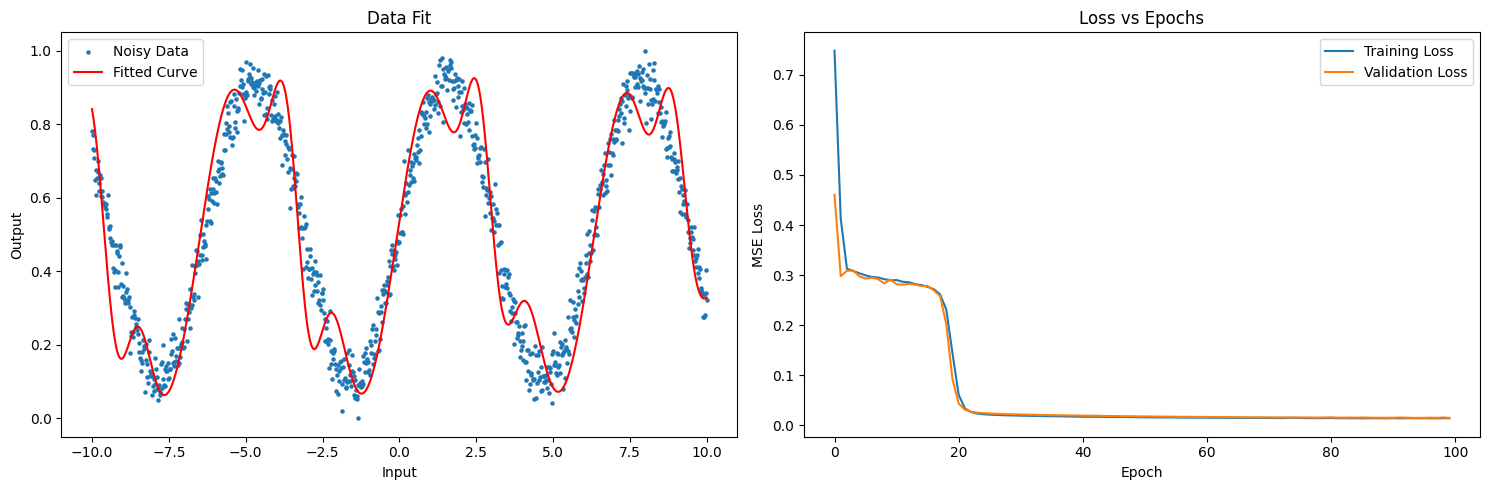

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()
Y_pred = M[0].predict(X, verbose = 0)
axes[0].scatter(X, Y, s=5, label='Noisy Data')
axes[0].plot(X, Y_pred, label='Fitted Curve', color='r')
#axes[0].plot(X, Y, label='True Curve', color='g')
axes[0].set_title('Data Fit')
axes[0].set_xlabel('Input')
axes[0].set_ylabel('Output')
axes[0].legend()

axes[1].plot(H[0].history['loss'], label='Training Loss')
axes[1].plot(H[0].history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss vs Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [6]:
# Function for training models with different configurations
def train_models(input_data, target_data, split = 0.20, cutoff_dim = 10, configs = [(6, 50)]):
    trained_models = []
    histories = []
    quantumness = []
    
    for num_layers, epochs in configs:
        # Create a new model for each configuration
        vacuum_state = get_vacuum_state_tf(cutoff_dim)
        model = tf.keras.Sequential([QEncoder(dim=cutoff_dim, vacuum_state=vacuum_state, name='QuantumEncoding')])
        for i in range(num_layers):
            model.add(QLayer(dim=cutoff_dim, name=f'QuantumLayer_{i+1}'))
        model.add(QDecoder(dim=cutoff_dim, name='QuantumDecoding'))

        # Compile and train the model
        model.compile(optimizer='adam', loss='mse')
        print(f'Training model with {num_layers} layers for {epochs} epochs...')
        showprogress = TQDMProgressBar()
        callback = [showprogress]
        history = model.fit(input_data, target_data, validation_split=split, epochs=epochs, verbose=0, callbacks=callback)

        # Store the trained model and its history
        histories.append(history)
        trained_models.append(model)

        print('Training Complete.')
        model.summary()

    return trained_models, histories